In [ ]:
# Grant access to google drive.
# Run this cell, then you’ll see a link, click on that link, allow access
# Copy the code that pops up, paste it in the box, hit Enter
import os
from google.colab import drive
drive.mount('/content/gdrive')

# # Change working directory to be current folder
# # os.chdir('/content/gdrive/My Drive/Your Folder Name/Your sub Folder Name')
# os.chdir('/content/gdrive/My Drive/xunfei_emotion_recognition')
# !ls


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pwd

/content


In [ ]:
!mkdir train_local
!unzip gdrive/MyDrive/xunfei_emotion_recognition/train.zip -d train_local/train
!unzip gdrive/MyDrive/xunfei_emotion_recognition/test.zip -d train_local/test

流式输出内容被截断，只能显示最后 5000 行内容。
 extracting: train_local/test/test/00636.png  
 extracting: train_local/test/test/01528.png  
 extracting: train_local/test/test/06247.png  
 extracting: train_local/test/test/02021.png  
 extracting: train_local/test/test/05996.png  
 extracting: train_local/test/test/04450.png  
 extracting: train_local/test/test/04336.png  
 extracting: train_local/test/test/03459.png  
 extracting: train_local/test/test/02747.png  
 extracting: train_local/test/test/05028.png  
 extracting: train_local/test/test/06521.png  
 extracting: train_local/test/test/00150.png  
 extracting: train_local/test/test/06535.png  
 extracting: train_local/test/test/00144.png  
 extracting: train_local/test/test/04322.png  
 extracting: train_local/test/test/02753.png  
 extracting: train_local/test/test/02035.png  
 extracting: train_local/test/test/05982.png  
 extracting: train_local/test/test/04444.png  
 extracting: train_local/test/test/00622.png  
 extracting: train_local/test/tes

# setup

In [ ]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE 
import os
import cv2
from collections import Counter
import random

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,LearningRateScheduler,ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import sklearn
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.test.gpu_device_name())
print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


/device:GPU:0
Versions of key libraries
---
tensorflow:  2.6.0
numpy:       1.19.5
matplotlib:  3.2.2
sklearn:     0.22.2.post1


In [ ]:
# basic setting
def implt(img):
    plt.figure()
    plt.imshow(img)
    plt.axis('off')

plt.style.use('seaborn')                   # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['figure.figsize']  = [7,7]   # Set the figure size to be 7 inch for (width,height)

print("Matplotlib setup completes.")

Matplotlib setup completes.


# Configure the hyperparameters

In [ ]:
SEED=66
np.random.seed(SEED)
random.seed(SEED)

NUM_CLASSES= 7
LR = 0.00375
BATCH_SIZE = 128
NUM_EPOCHS = 100
IMAGE_SIZE = 128  # We'll resize input images to this size
IMG_TARGET_SIZE =128

#load data

In [ ]:
#load data form dir
directory='train_local/train'
dir_list=os.listdir(directory)
print('label:',dir_list)

#1. read gray and expand dimension
grayscale=False
image_data_list=[]
labels=[]
emotions=[]
l=0
for data_dir in dir_list:
    data_list=os.listdir(directory+'/'+data_dir)
    for img in data_list:
      if grayscale:
        #read as grayscale
        input_img=cv2.imread(directory+'/'+data_dir+'/'+img,cv2.IMREAD_GRAYSCALE)
        input_img=cv2.resize(input_img,(IMAGE_SIZE,IMAGE_SIZE))
        input_img=np.expand_dims(input_img, axis=2)
        image_data_list.append(input_img)
        labels.append(l)
      else:
        #read as rgb
        input_img=cv2.imread(directory+'/'+data_dir+'/'+img)
        input_img=cv2.resize(input_img,(IMAGE_SIZE,IMAGE_SIZE))
        image_data_list.append(input_img)
        labels.append(l)
    emotions.append(data_dir)
    l=l+1

dataset_data=np.array(image_data_list)
dataset_label=np.array(labels)
print(dataset_data.shape) 

label: ['angry', 'surprised', 'fearful', 'neutral', 'sad', 'disgusted', 'happy']
(28709, 128, 128, 3)


In [ ]:
#split dataset
train_x, test_x, train_y, test_y = train_test_split(dataset_data, dataset_label, test_size=0.2,random_state=SEED) 
print('data_shape:',len(dataset_label),train_x.shape,train_y.shape,test_x.shape,test_y.shape)
print('train_label:',Counter(train_y.flatten()))
print('test_label:',Counter(test_y.flatten()))

data_shape: 28709 (22967, 128, 128, 3) (22967,) (5742, 128, 128, 3) (5742,)
train_label: Counter({6: 5741, 3: 3983, 4: 3859, 2: 3299, 0: 3196, 1: 2560, 5: 329})
test_label: Counter({6: 1474, 3: 982, 4: 971, 0: 799, 2: 798, 1: 611, 5: 107})


In [ ]:
#data oversample
train_x=train_x.reshape(train_x.shape[0],-1)
train_y=train_y.reshape(train_y.shape[0],-1)
print(train_x.shape,train_y.shape)
print('train_label:',Counter(train_y.flatten()))
print('test_label:',Counter(test_y.flatten()))
# smote
sm = SMOTE(random_state=0)    
train_x, train_y = sm.fit_resample(train_x, train_y)
print('train_label:',Counter(train_y))
print('test_label:',Counter(test_y))
print(train_x.shape,train_y.shape)
train_x=train_x.reshape(train_x.shape[0],48,48,1)
train_y=train_y.reshape(train_y.shape[0])
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)   
#focal loss label smooth 

In [ ]:
np.save('gdrive/MyDrive/xunfei_emotion_recognition/train_x.npy',train_x)
np.save('gdrive/MyDrive/xunfei_emotion_recognition/train_y.npy',train_y)
np.save('gdrive/MyDrive/xunfei_emotion_recognition/test_x.npy',test_x)
np.save('gdrive/MyDrive/xunfei_emotion_recognition/test_y.npy',test_y)

In [ ]:
train_x=np.load('gdrive/MyDrive/xunfei_emotion_recognition/train_x.npy')
train_y=np.load('gdrive/MyDrive/xunfei_emotion_recognition/train_y.npy')
test_x=np.load('gdrive/MyDrive/xunfei_emotion_recognition/test_x.npy')
test_y=np.load('gdrive/MyDrive/xunfei_emotion_recognition/test_y.npy')

(22967, 128, 128, 3)


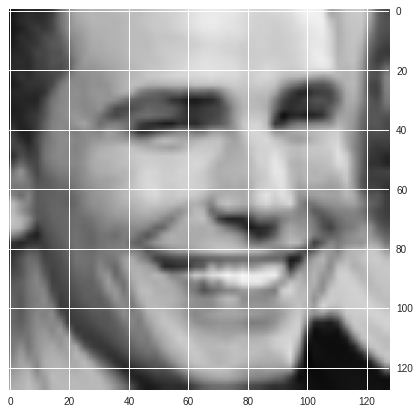

In [ ]:
print(train_x.shape)
plt.imshow(train_x[0])

In [ ]:
#data augument 
train_y = tf.keras.utils.to_categorical(train_y, NUM_CLASSES)
test_y = tf.keras.utils.to_categorical(test_y, NUM_CLASSES)
train_dir='train_local/train'

data_generator_with_aug = ImageDataGenerator(rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.4,1.5],
        fill_mode='nearest',
        validation_split=0.1)

data_generator_no_aug = ImageDataGenerator(rescale=1.0/255)


data_generator_no_aug = ImageDataGenerator(rescale=1.0/255)

train_data=data_generator_with_aug.flow(train_x, train_y,batch_size = BATCH_SIZE,shuffle=True)
           
val_data=data_generator_no_aug.flow(test_x, test_y,batch_size = BATCH_SIZE,shuffle=True)
print()

STEP_SIZE_TRAIN = train_data.n // train_data.batch_size
STEP_SIZE_VALID = val_data.n // val_data.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)


179 44


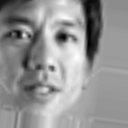

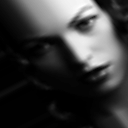

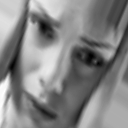

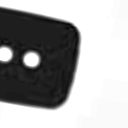

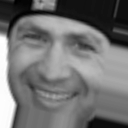

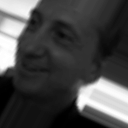

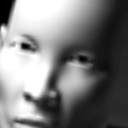

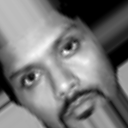

In [ ]:
sample_x, sample_y = next(train_data)
for i in range(8):
    display(tf.keras.utils.array_to_img(sample_x[i]))

In [ ]:
!pip install --quiet vit-keras
!pip install tensorflow-addons
!pip install stn
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


# model

In [ ]:
# from vit_keras import vit

# vit_model = vit.vit_b32(
#         image_size = IMAGE_SIZE,
#         activation = 'softmax',
#         pretrained = False,
#         include_top = False,
#         pretrained_top = False,
#         classes = NUM_CLASSES)

(128, 128, 3)


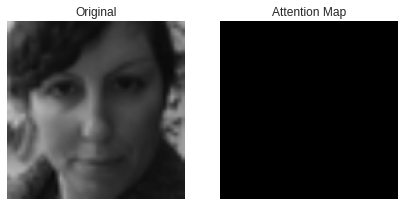

In [ ]:
# from vit_keras import visualize

# tmp = val_data.next()
# image = tmp[0][0]
# print(image.shape)
# attention_map = visualize.attention_map(model = vit_model, image = image)

# # Plot results
# fig, (ax1, ax2) = plt.subplots(ncols = 2)
# ax1.axis('off')
# ax2.axis('off')
# ax1.set_title('Original')
# ax2.set_title('Attention Map')
# _ = ax1.imshow(image)
# _ = ax2.imshow(attention_map)

In [ ]:
import tensorflow_addons as tfa
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(14, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(7, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b32 (Functional)         (None, 768)               87429888  
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 768)               3072      
_________________________________________________________________
dense (Dense)                (None, 14)                10766     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14)                56        
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 105       
Total params: 87,443,887
Trainable params: 87,442,323
Non-trainable params: 1,564
________________________________

In [ ]:
learning_rate = 1e-2

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tfa.losses.SigmoidFocalCrossEntropy(), 
              metrics = ['accuracy'])


STEP_SIZE_TRAIN = train_data.n // train_data.batch_size
STEP_SIZE_VALID = val_data.n // val_data.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

# earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
#                                                  min_delta = 1e-4,
#                                                  patience = 5,
#                                                  mode = 'max',
#                                                  restore_best_weights = True,
#                                                  verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [reduce_lr, checkpointer]

model_history=model.fit(x = train_data,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = val_data,
          validation_steps = STEP_SIZE_VALID,
          epochs = NUM_EPOCHS,
          callbacks = callbacks)

model.save('model.h5', save_weights_only = True)

Epoch 1/100


KeyboardInterrupt: ignored

In [ ]:
def plot_performance(history):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val loss evolution')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val accuracy')
plot_performance(model_history)

NameError: ignored

In [ ]:
predicted_classes = np.argmax(model.predict(val_data, steps = val_data.n // val_data.batch_size + 1), axis = 1)
print(predicted_classes)
true_classes = np.argmax(test_y,axis=1)
print(true_classes)
class_labels = dir_list  

confusionmatrix = metrics.confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))

[5 5 5 ... 5 2 5]
[[0 4 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 6 0 ... 0 0 0]
 ...
 [0 3 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 6 0 ... 0 0 0]]


ValueError: ignored

# model2

In [ ]:
import tensorflow_addons as tfa
from tensorflow import keras
from keras import layers
from stn import spatial_transformer_network as transformer

def createModel(grayscale=False):
  img_inputs = keras.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))

  locnet = layers.Conv2D(32,3, padding='same')(img_inputs)
  locnet = layers.MaxPooling2D(3, padding='same')(locnet)
  locnet = layers.Activation('relu')(locnet)
  locnet = layers.BatchNormalization()(locnet)
  locnet = layers.Conv2D(64,3, padding='same')(locnet)
  locnet = layers.MaxPooling2D(3, padding='same')(locnet)
  locnet = layers.Activation('relu')(locnet)
  locnet = layers.BatchNormalization()(locnet)
  locnet = layers.Conv2D(96,3, padding='same')(locnet)
  feat_map = layers.Activation('relu')(locnet)
  locnet = layers.BatchNormalization()(locnet)
  locnet = layers.Flatten()(feat_map)
  locnet = layers.Dense(90, activation='relu',kernel_regularizer='l2')(locnet)
  locnet = layers.Dropout(0.2)(locnet)
  locnet = layers.Dense(32, activation='relu', kernel_regularizer='l2')(locnet)
  theta = layers.Dense(6, activation='linear')(locnet)

  locnet = keras.Model(img_inputs, theta, name="locnet")
  #locnet.summary()

  #spatial transformer network
  outstn = transformer(feat_map,theta)



  #feature extraction network
  fe = layers.Conv2D(32,3, padding='same')(img_inputs)
  fe = layers.BatchNormalization()(fe)
  fe = layers.Activation('relu')(fe)
  fe = layers.MaxPooling2D(3,padding='same')(fe)
  fe = layers.Conv2D(64,3, padding='same')(fe)
  fe = layers.BatchNormalization()(fe)
  fe = layers.Activation('relu')(fe)
  fe = layers.MaxPooling2D(3,padding='same')(fe)
  fe = layers.Conv2D(96,3, padding='same')(fe)
  fe = layers.Activation('relu')(fe)
  do = layers.BatchNormalization()(fe)

  fe = keras.Model(img_inputs, do, name="feature extractor")
  #fe.summary()

  add = layers.Add()([outstn, do])

  flats = layers.Flatten()(add)
  flats = layers.Dense(64, activation='relu',  kernel_regularizer='l2')(flats)
  flats = layers.Dropout(0.4)(flats)
  flats = layers.Dense(32, activation='relu',  kernel_regularizer='l2')(flats)
  flats = layers.Dropout(0.4)(flats)
  #output = layers.Dense(6, activation='softmax')(flats)

  x1 = layers.Dense(7, activation='linear')(flats)
  x2 = layers.Dense(7,activation='linear')(flats)
  x3 = layers.Dense(7,activation='linear')(flats)
  x4 = layers.Dense(7,activation='linear')(flats)
  avg = layers.Average()([x1, x2, x3, x4])
  out = layers.Dense(7, activation='softmax')(avg)

  model = keras.Model(inputs=img_inputs, outputs=out, name="FEMSTN")
  return model
def createModel2():
  img_inputs = keras.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))
  model=tf.keras.applications.ResNet101V2(include_top=False, weights='imagenet', input_tensor=img_inputs,input_shape=None, pooling='avg', classes=7)
  x=tf.keras.layers.Flatten()(model.output)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.Dense(14, activation = tfa.activations.gelu)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  out=tf.keras.layers.Dense(7, 'softmax')(x)

  model = keras.Model(inputs=img_inputs, outputs=out, name="ResNet101V2")
  return model
# model       = createModel(grayscale=True)   # This is meant for training
# modelGo     = createModel(grayscale=True)   # This is used for final testing
model       = createModel2()   # This is meant for training
modelGo     = createModel2()   # This is used for final testing
model.summary() 

Model: "ResNet101V2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [ ]:
modelname='ResNet101V2'

callbacks_list  = []

es = EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=2,
    mode='max', baseline=None, restore_best_weights=True
)
callbacks_list.append(es)
lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=2,
    mode='max', min_delta=1e-5, cooldown=0, min_lr=0
)
callbacks_list.append(lr)

def lrSchedule(epoch):
    mode='progressive_drops'
    lr_base = LR
    lr_decay = 0.1
    lr = lr_base
    epochs=NUM_EPOEHES
    if mode == 'power_decay':
        # original lr schedulera
        lr = lr_base * ((1 - float(epoch) / epochs) ** lr_power)
    if mode == 'exp_decay':
        # exponential decay
        lr = (float(lr_base) ** float(lr_power)) ** float(epoch + 1)
    # adam default lr
    if mode == 'adam':
        lr = 0.001

    if mode == 'progressive_drops':
       if epoch > 0.9 * epochs:
          lr = lr*lr_decay*lr_decay*lr_decay
       elif epoch > 0.75 * epochs:
          lr = lr*lr_decay*lr_decay
       elif epoch > 0.5 * epochs:
          lr = lr*lr_decay
       else:
          lr = lr_base

    print('lr: %f' % lr)
    return lr

LRScheduler     = LearningRateScheduler(lrSchedule)
# callbacks_list.append(LRScheduler)
                                                                                
folderpath      = '/content/gdrive/MyDrive/xunfei_emotion_recognition/'
filepath        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=1, 
                                  save_best_only=True, 
                                  mode='max')
callbacks_list.append(checkpoint)
csv_logger      = CSVLogger(folderpath+modelname +'.csv',append=False)                       
callbacks_list.append(csv_logger)                     

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print(callbacks_list[2])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')

Callbacks created:

Path to model: /content/gdrive/MyDrive/xunfei_emotion_recognition/ResNet101V2.hdf5
Path to log:   /content/gdrive/MyDrive/xunfei_emotion_recognition/ResNet101V2.csv


In [ ]:
optimizer = tf.optimizers.Adam(tf.keras.optimizers.schedules.CosineDecay(LR,100)) 
model.compile(optimizer = optimizer, 
              loss = tfa.losses.SigmoidFocalCrossEntropy(reduction=tf.keras.losses.Reduction.AUTO), 
              # loss='categorical_crossentropy',
              metrics = ['accuracy'])

model_history=model.fit(x = train_data,
          validation_data = val_data,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_steps = STEP_SIZE_VALID,
          epochs = NUM_EPOCHS,
           verbose=1,
          callbacks=callbacks_list) 

Epoch 1/100


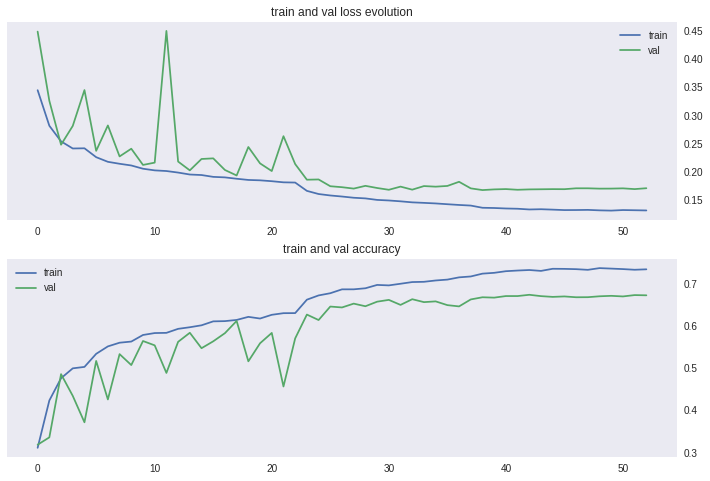

In [ ]:
def plot_performance(history):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val loss evolution')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val accuracy')
plot_performance(model_history)

# plot result

In [ ]:
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

predicts    = modelGo.predict(dataset_data)                                            # Step 2
print("Prediction completes.")

In [ ]:
confusion   = metrics.confusion_matrix(testout,predout)
print(confusion)

records     = pd.read_csv(folderpath+modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'], label="validation")
plt.plot(records['loss'],label="training")
plt.yticks([0.00,0.50,1.00,1.50])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_accuracy'],label="validation")
plt.plot(records['accuracy'],label="training")
plt.yticks([0.5,0.6,0.7,0.8])
plt.title('Accuracy',fontsize=12)
ax.legend()
plt.show()

In [ ]:
model.load_weights('/content/gdrive/My Drive/xunfei_emotion_recognition/simple_FEMSTN.hdf5')
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        './train_local/test',
        target_size=(48, 48),
        color_mode="grayscale",
        shuffle = False,
        class_mode='categorical',
        )

filenames = test_generator.filenames
nb_samples = len(filenames)
predict = model.predict(test_generator,steps = nb_samples)

Found 7178 images belonging to 1 classes.


In [ ]:
train_data.class_indices

In [ ]:
import numpy as np
import pandas as pd
cls_name = np.array(dir_list)

In [ ]:
submit_df = pd.DataFrame({'name': filenames, 'label': cls_name[predict.argmax(1)]})

In [ ]:
submit_df.head()

,name,label
0,test/00001.png,angry
1,test/00002.png,sad
2,test/00003.png,angry
3,test/00004.png,angry
4,test/00005.png,surprised


In [ ]:
submit_df = submit_df[submit_df['name'].apply(lambda x: 'test' in x )]
submit_df['name'] = submit_df['name'].apply(lambda x: x.split('/')[-1])

In [ ]:
submit_df = submit_df.sort_values(by='name')
submit_df.to_csv('submit.csv', index=None)